In [60]:
from scipy import stats
import math

class City:
    def __init__(self, name, population,mean_leave):
        self.name = name
        self.population = population
        self.mean_leave = mean_leave

    def onramp(self, time):
        st_dev = 33
        commuters_percentage = 0.10
        #Calculate the z-score for the normal dist. at the current time and the last time
        z_now = (time-self.mean_leave) / st_dev
        z_last = ((time-1)-self.mean_leave) / st_dev
        #Calculate the probability of a car entering the highway in the last minute
        cdf_now = stats.norm.cdf(z_now)
        cdf_last = stats.norm.cdf(z_last)
        probability = cdf_now - cdf_last
        #Calculate the expected number of cars entering in the last minute
        cars_coming_on = math.floor(probability*commuters_percentage*self.population)
        return cars_coming_on
    
class Road:
    global free_flow_speed, jam_density
    free_flow_speed = 110/60 #110 is the free flow speed in km/h, so 110/60 is km/min
    jam_density = 135
    def __init__(self, length, lanes, onramp_city):
        self.length = length
        self.lanes= lanes
        self.city = onramp_city
        self.vehicle_count = 1
        
    def outflow(self):
        density = self.vehicle_count / (self.lanes * self.length)
        #jam_density is the carrying capacity
        outflow = max(free_flow_speed*density*(1 - (density/jam_density)),0) 
        return outflow
    
    def update(self,time,road_inflow):
        outflow = self.outflow()
        if (self.outflow()>0 and self.vehicle_count>outflow): 
            onramp_inflow = self.city.onramp(time)
            self.vehicle_count = math.floor(self.vehicle_count + onramp_inflow + road_inflow - outflow)
            return self.vehicle_count
        elif (self.outflow()==0):
            ## when the state is 'jammed' we stop all inputs. 
             ##This assumes all cars upon arriving at jammed section are longer part of the equation (no backup to other sections occur)
             #We should never have an outflow of 0 as there may be jammed, stopped section but cars will always be leaving a 
             # section to the next, even at a very low rate. 
             # With time step of one minute, we can set a minimum of leaving cars to be the number of lanes times
             # 10 'rows' of cars per time step of 1min. This value 10 is a assumption   
            self.vehicle_count = max(math.floor(self.vehicle_count - self.lanes*10),1)
            return self.vehicle_count
        elif (self.vehicle_count<outflow):
            self.vehicle_count = 1
            return self.vehicle_count

In [61]:
total = 0
stdev = 100
time_values = [s/1000 for s in range(-10000,10000)]

percentages = []
for inc in range(len(time_values)-1):
    cdf_1 = stats.norm.cdf(time_values[inc])
    cdf_2 = stats.norm.cdf(time_values[inc+1])
    diff = cdf_2 - cdf_1
    percentages.append(diff)
print(sum(percentages))

1.0


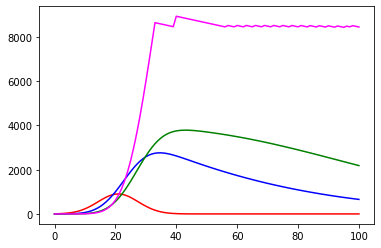

In [62]:
# odeint performed on SIR model
import numpy as np
import scipy.integrate as integrate 
import matplotlib.pyplot as plt
from pylab import * 

#Note: t = 0 is 5:30 am

#Setup Our 4 cities
cities = [
    City(name="Hamilton",population=747545,mean_leave=100),
    City(name="Burlington",population=183314,mean_leave=115),
    City(name="Oakville",population=193832,mean_leave=135),
    City(name="Mississauga",population=721599,mean_leave=155)
]
#Setup Our 4 road segments
roads = [
    Road(length=11.1, lanes=3, onramp_city=cities[0]),
    Road(length=17.0, lanes=4, onramp_city=cities[1]),
    Road(length=13.8, lanes=4, onramp_city=cities[2]),
    Road(length=20.9, lanes=3, onramp_city=cities[3])
]

run_time=100  

def initialize():
    global w, x, y , z, wresult, xresult, yresult, zresult, time
    time = 1
    w = 1
    x = 1 
    y = 1 
    z = 1
    wresult = [w]
    xresult = [x]
    yresult = [y]
    zresult = [z]
    
def observe():
    global w, x, y , z, wresult, xresult, yresult, zresult, time
    wresult.append(w)
    xresult.append(x)
    yresult.append(y) 
    zresult.append(z)
    
def updateall():
    global w, x, y , z, wresult, xresult, yresult, zresult, time
    nextw = roads[0].city.onramp(time)
    nextx = roads[1].update(time, roads[0].outflow())
    nexty = roads[2].update(time, roads[1].outflow())
    nextz = roads[3].update(time, roads[2].outflow())
    w, x, y, z = nextw, nextx, nexty, nextz
    time = time + 5
    

initialize()

for t in range(run_time):
    updateall()
    observe() 
    
plot(wresult, color='red') 
plot(xresult, color='blue') 
plot(yresult, color='green')
plot(zresult, color='magenta') 

show()

In [63]:
print(yresult)

[1, 0, 1, 1, 1, 1, 1, 2, 4, 8, 14, 24, 38, 59, 88, 127, 180, 247, 332, 435, 559, 704, 871, 1057, 1260, 1478, 1706, 1939, 2172, 2400, 2618, 2821, 3007, 3172, 3315, 3436, 3536, 3615, 3676, 3721, 3752, 3772, 3782, 3786, 3783, 3776, 3766, 3753, 3738, 3722, 3704, 3685, 3666, 3646, 3626, 3605, 3583, 3561, 3538, 3514, 3490, 3465, 3440, 3414, 3387, 3360, 3332, 3304, 3275, 3246, 3216, 3186, 3155, 3124, 3092, 3060, 3028, 2995, 2962, 2929, 2895, 2861, 2827, 2792, 2757, 2722, 2687, 2652, 2616, 2580, 2544, 2508, 2472, 2436, 2400, 2364, 2328, 2292, 2256, 2220, 2184]
